# 04. LoRA 파인튜닝 - 효율적인 LLM 커스터마이징

## 🎯 학습 목표
1. 파인튜닝과 LoRA의 개념 이해
2. LoRA의 작동 원리와 장점 파악
3. PEFT 라이브러리를 활용한 구현
4. 실전 파인튜닝 프로젝트 수행

## 📚 파인튜닝이란?

## 1. 파인튜닝 기초 개념

### 파인튜닝 vs 사전학습 vs 프롬프팅

```
┌────────────────────────────────────────────────┐
│           LLM 커스터마이징 방법 비교            │
├────────────────────────────────────────────────┤
│                                                │
│  1. 프롬프팅 (Prompting)                      │
│     • 비용: 💰 (낮음)                          │
│     • 시간: ⏱️ (즉시)                          │
│     • 효과: ⭐⭐                               │
│                                                │
│  2. 파인튜닝 (Fine-tuning)                    │
│     • 비용: 💰💰💰 (높음)                      │
│     • 시간: ⏱️⏱️⏱️ (수일)                      │
│     • 효과: ⭐⭐⭐⭐⭐                        │
│                                                │
│  3. LoRA (Low-Rank Adaptation)                │
│     • 비용: 💰💰 (중간)                        │
│     • 시간: ⏱️⏱️ (수시간)                      │
│     • 효과: ⭐⭐⭐⭐                          │
└────────────────────────────────────────────────┘
```

### 전통적 파인튜닝의 문제점

1. **메모리 문제**: 7B 모델 = 28GB+ GPU 메모리 필요
2. **계산 비용**: 모든 파라미터 업데이트 → 높은 연산량
3. **저장 공간**: 각 태스크마다 전체 모델 저장
4. **과적합 위험**: 작은 데이터셋에서 성능 저하

## 2. LoRA의 핵심 원리

### LoRA (Low-Rank Adaptation)란?

**핵심 아이디어**: 큰 행렬의 변화를 작은 행렬의 곱으로 표현

```
원본 가중치 업데이트:           LoRA 방식:
                              
    W (d×d)                    W (고정) + ΔW
                                         ↓
  큰 행렬 전체                 W + B×A
  업데이트 필요                   (d×r)(r×d)
                                    ↓
  d²개 파라미터                2×d×r개 파라미터
                              (r << d일 때 효율적)
```

### 수학적 표현

- **원본**: `h = Wx`
- **LoRA**: `h = Wx + BAx = (W + BA)x`
  - `W`: 원본 가중치 (고정)
  - `B`: d×r 행렬 (학습)
  - `A`: r×d 행렬 (학습)
  - `r`: rank (일반적으로 4~64)

### LoRA의 장점

| 측면 | 전통적 파인튜닝 | LoRA |
|-----|----------------|------|
| 학습 파라미터 | 100% (7B) | 0.1% (7MB) |
| GPU 메모리 | 28GB+ | 6GB |
| 학습 시간 | 수일 | 수시간 |
| 모델 저장 | 7GB × N개 | 7GB + (7MB × N개) |
| 추론 속도 | 동일 | 동일 (병합 후) |

## 3. 환경 설정

In [ ]:
# 필요 패키지 설치
!pip install transformers peft accelerate bitsandbytes datasets -q

In [2]:
import torch
import torch.nn as nn
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    prepare_model_for_kbit_training
)
from datasets import Dataset, load_dataset
import numpy as np

# GPU 확인
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

/opt/homebrew/anaconda3/envs/ai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


## 4. LoRA 구성 상세 설명

In [3]:
# LoRA 설정 파라미터 이해하기

def explain_lora_config():
    """LoRA 설정 파라미터 설명"""
    
    config_explanation = {
        "r (rank)": {
            "설명": "LoRA 행렬의 차원 (낮을수록 효율적, 높을수록 표현력↑)",
            "일반값": "4, 8, 16, 32, 64",
            "선택기준": "태스크 복잡도에 비례"
        },
        "lora_alpha": {
            "설명": "LoRA 스케일링 파라미터 (learning rate와 유사)",
            "일반값": "16, 32, 64",
            "선택기준": "일반적으로 r × 2"
        },
        "lora_dropout": {
            "설명": "과적합 방지를 위한 드롭아웃",
            "일반값": "0.05 ~ 0.1",
            "선택기준": "데이터셋 크기에 반비례"
        },
        "target_modules": {
            "설명": "LoRA를 적용할 레이어",
            "일반값": "['q_proj', 'v_proj'] 또는 ['q_proj', 'k_proj', 'v_proj', 'o_proj']",
            "선택기준": "더 많은 모듈 = 더 높은 성능, 더 많은 메모리"
        }
    }
    
    for key, value in config_explanation.items():
        print(f"\n📌 {key}")
        for key, value in value.items():
            print(f"  • {key}: {value}")

explain_lora_config()


📌 r (rank)
  • 설명: LoRA 행렬의 차원 (낮을수록 효율적, 높을수록 표현력↑)
  • 일반값: 4, 8, 16, 32, 64
  • 선택기준: 태스크 복잡도에 비례

📌 lora_alpha
  • 설명: LoRA 스케일링 파라미터 (learning rate와 유사)
  • 일반값: 16, 32, 64
  • 선택기준: 일반적으로 r × 2

📌 lora_dropout
  • 설명: 과적합 방지를 위한 드롭아웃
  • 일반값: 0.05 ~ 0.1
  • 선택기준: 데이터셋 크기에 반비례

📌 target_modules
  • 설명: LoRA를 적용할 레이어
  • 일반값: ['q_proj', 'v_proj'] 또는 ['q_proj', 'k_proj', 'v_proj', 'o_proj']
  • 선택기준: 더 많은 모듈 = 더 높은 성능, 더 많은 메모리


## 5. 간단한 LoRA 예제 (시뮬레이션)

In [4]:
# LoRA 원리를 보여주는 간단한 시뮬레이션

class SimpleLoRA(nn.Module):
    """LoRA 원리 시연용 간단한 구현"""
    
    def __init__(self, in_features, out_features, rank=4):
        super().__init__()
        
        # 원본 가중치 (고정)
        self.W = nn.Linear(in_features, out_features, bias=False)
        self.W.weight.requires_grad = False  # 고정!
        
        # LoRA 파라미터 (학습 가능)
        self.lora_A = nn.Linear(in_features, rank, bias=False)
        self.lora_B = nn.Linear(rank, out_features, bias=False)
        
        # 초기화
        nn.init.kaiming_uniform_(self.lora_A.weight)
        nn.init.zeros_(self.lora_B.weight)
        
        self.rank = rank
    
    def forward(self, x):
        # 원본 출력 + LoRA 출력
        original = self.W(x)
        lora = self.lora_B(self.lora_A(x))
        return original + lora
    
    def count_parameters(self):
        """파라미터 수 계산"""
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        
        return {
            "total": total,
            "trainable": trainable,
            "fixed": total - trainable,
            "reduction": f"{(1 - trainable/total)*100:.1f}%"
        }

# 예제: 768차원 임베딩 (BERT 크기)
d = 768
ranks = [4, 8, 16, 32, 64]

print("LoRA Rank별 파라미터 수 비교")
print("="*50)

for r in ranks:
    lora_layer = SimpleLoRA(d, d, rank=r)
    stats = lora_layer.count_parameters()
    
    print(f"\nRank={r:2d}:")
    print(f"  • 원본 파라미터: {stats['fixed']:,}")
    print(f"  • LoRA 파라미터: {stats['trainable']:,}")
    print(f"  • 절감률: {stats['reduction']}")

LoRA Rank별 파라미터 수 비교

Rank= 4:
  • 원본 파라미터: 589,824
  • LoRA 파라미터: 6,144
  • 절감률: 99.0%

Rank= 8:
  • 원본 파라미터: 589,824
  • LoRA 파라미터: 12,288
  • 절감률: 98.0%

Rank=16:
  • 원본 파라미터: 589,824
  • LoRA 파라미터: 24,576
  • 절감률: 96.0%

Rank=32:
  • 원본 파라미터: 589,824
  • LoRA 파라미터: 49,152
  • 절감률: 92.3%

Rank=64:
  • 원본 파라미터: 589,824
  • LoRA 파라미터: 98,304
  • 절감률: 85.7%


## 6. 실전: 작은 모델로 LoRA 파인튜닝

In [6]:
class MiniLoRATrainer:
    """간단한 LoRA 파인튜닝 예제"""
    
    def __init__(self, model_name="gpt2"):  # 작은 모델 사용
        self.model_name = model_name
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
    def setup_model_and_tokenizer(self):
        """모델과 토크나이저 설정"""
        
        print(f"Loading {self.model_name}...")
        
        # 토크나이저
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        
        # 모델 (8-bit 양자화 옵션)
        if self.device == "cuda":
            self.model = AutoModelForCausalLM.from_pretrained(
                self.model_name,
                load_in_8bit=True,  # 메모리 절약
                device_map="auto"
            )
        else:
            self.model = AutoModelForCausalLM.from_pretrained(
                self.model_name,
                torch_dtype=torch.float32
            )
        
        print(f"✅ Model loaded: {self.model.__class__.__name__}")
        
    def apply_lora(self, r=8, alpha=32, dropout=0.1):
        """LoRA 적용"""
        
        # LoRA 설정
        lora_config = LoraConfig(
            r=r,
            lora_alpha=alpha,
            lora_dropout=dropout,
            bias="none",
            task_type=TaskType.CAUSAL_LM,
            target_modules=["c_attn", "c_proj"]  # GPT2 레이어
        )
        
        # PEFT 모델 생성
        self.model = get_peft_model(self.model, lora_config)
        
        # 학습 가능 파라미터 출력
        self.model.print_trainable_parameters()
        
    def prepare_dataset(self, texts, max_length=128):
        """데이터셋 준비"""
        
        def tokenize(examples):
            return self.tokenizer(
                examples["text"],
                truncation=True,
                padding="max_length",
                max_length=max_length
            )
        
        # Dataset 생성
        dataset = Dataset.from_dict({"text": texts})
        tokenized = dataset.map(tokenize, batched=True)
        
        return tokenized

# 사용 예제 (실제 실행은 GPU 필요)
trainer = MiniLoRATrainer("gpt2")

print("📝 LoRA 파인튜닝 설정 예제")
print("-" * 50)
print("""
# 1. 모델 로드
trainer.setup_model_and_tokenizer()

# 2. LoRA 적용
trainer.apply_lora(r=8, alpha=16, dropout=0.1)

# 3. 데이터 준비
texts = ["Example text 1", "Example text 2"]
dataset = trainer.prepare_dataset(texts)

# 4. 학습 (실제로는 Trainer 사용)
""")

📝 LoRA 파인튜닝 설정 예제
--------------------------------------------------

# 1. 모델 로드
trainer.setup_model_and_tokenizer()

# 2. LoRA 적용
trainer.apply_lora(r=8, alpha=16, dropout=0.1)

# 3. 데이터 준비
texts = ["Example text 1", "Example text 2"]
dataset = trainer.prepare_dataset(texts)

# 4. 학습 (실제로는 Trainer 사용)



## 7. 데이터셋 준비 전략

In [7]:
class DatasetBuilder:
    """파인튜닝용 데이터셋 생성"""
    
    @staticmethod
    def create_instruction_dataset():
        """인스트럭션 튜닝 데이터셋"""
        
        instructions = [
            {
                "instruction": "Python에서 리스트를 역순으로 정렬하는 방법을 알려주세요.",
                "input": "",
                "output": "리스트를 역순으로 정렬하는 방법:\n1. list.reverse() - 원본 수정\n2. reversed(list) - 이터레이터 반환\n3. list[::-1] - 새 리스트 반환\n4. sorted(list, reverse=True) - 정렬 후 역순"
            },
            {
                "instruction": "딕셔너리와 리스트의 차이점을 설명하세요.",
                "input": "",
                "output": "딕셔너리 vs 리스트:\n• 리스트: 순서가 있는 컬렉션, 인덱스로 접근\n• 딕셔너리: 키-값 쌍, 키로 접근, 순서 보장(3.7+)\n• 리스트는 []사용, 딕셔너리는 {} 사용"
            },
            {
                "instruction": "주어진 코드의 시간복잡도를 분석하세요.",
                "input": "for i in range(n):\n    for j in range(n):\n        print(i, j)",
                "output": "시간복잡도: O(n²)\n이유: 중첩된 반복문이 각각 n번 실행되므로 총 n×n = n² 번 실행됩니다."
            }
        ]
        
        # Alpaca 형식으로 변환
        formatted_data = []
        for item in instructions:
            if item["input"]:
                text = f"### Instruction:\n{item['instruction']}\n\n### Input:\n{item['input']}\n\n### Response:\n{item['output']}"
            else:
                text = f"### Instruction:\n{item['instruction']}\n\n### Response:\n{item['output']}"
            formatted_data.append(text)
        
        return formatted_data
    
    @staticmethod
    def create_chat_dataset():
        """대화형 데이터셋"""
        
        conversations = [
            {
                "messages": [
                    {"role": "user", "content": "머신러닝과 딥러닝의 차이는?"},
                    {"role": "assistant", "content": "머신러닝은 데이터에서 패턴을 학습하는 AI의 한 분야이고, 딥러닝은 인공신경망을 사용하는 머신러닝의 하위 분야입니다. 딥러닝은 더 복잡한 패턴을 학습할 수 있지만 더 많은 데이터와 연산이 필요합니다."}
                ]
            },
            {
                "messages": [
                    {"role": "user", "content": "REST API란?"},
                    {"role": "assistant", "content": "REST API는 웹 서비스 설계 아키텍처입니다. HTTP 메서드(GET, POST, PUT, DELETE)를 사용하여 리소스를 조작하고, 무상태성과 클라이언트-서버 구조를 특징으로 합니다."}
                ]
            }
        ]
        
        # ChatML 형식으로 변환
        formatted_data = []
        for conv in conversations:
            text = ""
            for msg in conv["messages"]:
                if msg["role"] == "user":
                    text += f"<|user|>\n{msg['content']}\n"
                else:
                    text += f"<|assistant|>\n{msg['content']}\n"
            formatted_data.append(text)
        
        return formatted_data

# 데이터셋 생성 예제
builder = DatasetBuilder()

print("📚 인스트럭션 데이터셋 예제:")
instruction_data = builder.create_instruction_dataset()
print(instruction_data[0][:200] + "...")

print("\n💬 대화형 데이터셋 예제:")
chat_data = builder.create_chat_dataset()
print(chat_data[0])

📚 인스트럭션 데이터셋 예제:
### Instruction:
Python에서 리스트를 역순으로 정렬하는 방법을 알려주세요.

### Response:
리스트를 역순으로 정렬하는 방법:
1. list.reverse() - 원본 수정
2. reversed(list) - 이터레이터 반환
3. list[::-1] - 새 리스트 반환
4. sorted(list, reverse=True) - 정렬...

💬 대화형 데이터셋 예제:
<|user|>
머신러닝과 딥러닝의 차이는?
<|assistant|>
머신러닝은 데이터에서 패턴을 학습하는 AI의 한 분야이고, 딥러닝은 인공신경망을 사용하는 머신러닝의 하위 분야입니다. 딥러닝은 더 복잡한 패턴을 학습할 수 있지만 더 많은 데이터와 연산이 필요합니다.



## 8. 학습 모니터링과 평가

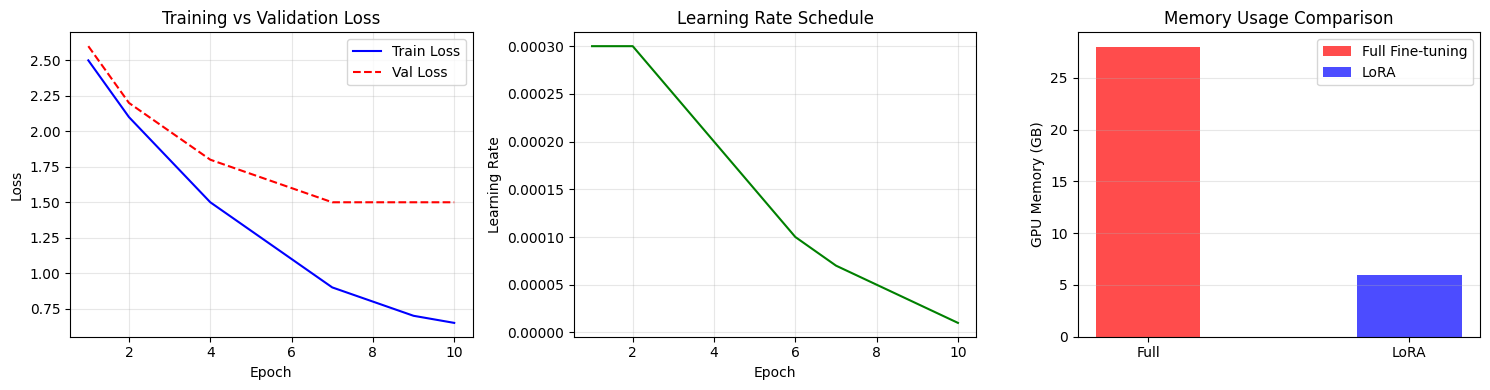

In [8]:
import matplotlib.pyplot as plt

def visualize_training_metrics():
    """학습 메트릭 시각화 (시뮬레이션)"""
    
    # 가상의 학습 데이터
    epochs = list(range(1, 11))
    train_loss = [2.5, 2.1, 1.8, 1.5, 1.3, 1.1, 0.9, 0.8, 0.7, 0.65]
    val_loss = [2.6, 2.2, 2.0, 1.8, 1.7, 1.6, 1.5, 1.5, 1.5, 1.5]
    learning_rate = [3e-4, 3e-4, 2.5e-4, 2e-4, 1.5e-4, 1e-4, 7e-5, 5e-5, 3e-5, 1e-5]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Loss 그래프
    axes[0].plot(epochs, train_loss, 'b-', label='Train Loss')
    axes[0].plot(epochs, val_loss, 'r--', label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training vs Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Learning Rate 그래프
    axes[1].plot(epochs, learning_rate, 'g-')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Learning Rate')
    axes[1].set_title('Learning Rate Schedule')
    axes[1].grid(True, alpha=0.3)
    
    # 메모리 사용량
    memory_full = [28, 28, 28, 28, 28, 28, 28, 28, 28, 28]
    memory_lora = [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
    
    x = [0.5, 1.5]
    axes[2].bar(x[0], np.mean(memory_full), width=0.4, label='Full Fine-tuning', color='red', alpha=0.7)
    axes[2].bar(x[1], np.mean(memory_lora), width=0.4, label='LoRA', color='blue', alpha=0.7)
    axes[2].set_ylabel('GPU Memory (GB)')
    axes[2].set_title('Memory Usage Comparison')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(['Full', 'LoRA'])
    axes[2].legend()
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

# 시각화 실행
visualize_training_metrics()

## 9. LoRA 병합과 배포

In [9]:
class LoRADeployment:
    """LoRA 모델 병합 및 배포"""
    
    @staticmethod
    def merge_and_save():
        """LoRA 가중치를 원본 모델에 병합"""
        
        print("🔄 LoRA 병합 프로세스")
        print("="*50)
        
        steps = [
            "1. LoRA 어댑터 로드",
            "2. 원본 모델 로드",
            "3. 가중치 병합: W_merged = W_original + B × A",
            "4. 병합된 모델 저장",
            "5. 추론 최적화"
        ]
        
        for step in steps:
            print(f"  {step}")
        
        print("\n💾 저장 옵션:")
        print("  • 어댑터만 저장: ~10MB (원본 모델 필요)")
        print("  • 병합 모델 저장: 전체 크기 (독립 실행 가능)")
        
    @staticmethod
    def deployment_strategies():
        """배포 전략"""
        
        strategies = {
            "1. 다중 어댑터": {
                "설명": "하나의 베이스 모델 + 여러 LoRA 어댑터",
                "장점": "메모리 효율적, 빠른 전환",
                "사용사례": "다국어 지원, 도메인별 커스터마이징"
            },
            "2. 병합 모델": {
                "설명": "LoRA를 원본에 병합한 단일 모델",
                "장점": "추론 속도 최적화",
                "사용사례": "프로덕션 배포"
            },
            "3. 동적 로딩": {
                "설명": "필요시 LoRA 어댑터 로드/언로드",
                "장점": "유연성, 메모리 관리",
                "사용사례": "멀티테넌트 서비스"
            }
        }
        
        print("\n🚀 LoRA 배포 전략")
        print("="*50)
        
        for name, info in strategies.items():
            print(f"\n{name}")
            for key, value in info.items():
                print(f"  • {key}: {value}")

# 실행
deployment = LoRADeployment()
deployment.merge_and_save()
deployment.deployment_strategies()

🔄 LoRA 병합 프로세스
  1. LoRA 어댑터 로드
  2. 원본 모델 로드
  3. 가중치 병합: W_merged = W_original + B × A
  4. 병합된 모델 저장
  5. 추론 최적화

💾 저장 옵션:
  • 어댑터만 저장: ~10MB (원본 모델 필요)
  • 병합 모델 저장: 전체 크기 (독립 실행 가능)

🚀 LoRA 배포 전략

1. 다중 어댑터
  • 설명: 하나의 베이스 모델 + 여러 LoRA 어댑터
  • 장점: 메모리 효율적, 빠른 전환
  • 사용사례: 다국어 지원, 도메인별 커스터마이징

2. 병합 모델
  • 설명: LoRA를 원본에 병합한 단일 모델
  • 장점: 추론 속도 최적화
  • 사용사례: 프로덕션 배포

3. 동적 로딩
  • 설명: 필요시 LoRA 어댑터 로드/언로드
  • 장점: 유연성, 메모리 관리
  • 사용사례: 멀티테넌트 서비스


## 10. 실전 프로젝트: 도메인 특화 챗봇

In [10]:
class DomainSpecificBot:
    """도메인 특화 챗봇 파인튜닝 프로젝트"""
    
    def __init__(self, domain="customer_service"):
        self.domain = domain
        self.domains = {
            "customer_service": {
                "description": "고객 서비스 챗봇",
                "sample_data": [
                    "Q: 환불 정책은 어떻게 되나요?\nA: 구매 후 14일 이내 미사용 제품에 한해 전액 환불 가능합니다.",
                    "Q: 배송은 얼마나 걸리나요?\nA: 일반 배송은 2-3일, 특급 배송은 당일 또는 익일 도착합니다.",
                    "Q: 회원 등급 혜택은?\nA: 실버(5%), 골드(10%), 플래티넘(15%) 할인 혜택이 있습니다."
                ]
            },
            "medical": {
                "description": "의료 상담 어시스턴트",
                "sample_data": [
                    "Q: 두통이 자주 있어요\nA: 충분한 수분 섭취와 규칙적인 수면이 중요합니다. 증상이 지속되면 의사 상담을 권합니다.",
                    "Q: 건강검진 주기는?\nA: 20-30대는 2년마다, 40대 이상은 매년 권장됩니다."
                ]
            },
            "legal": {
                "description": "법률 자문 어시스턴트",
                "sample_data": [
                    "Q: 계약서 검토 포인트는?\nA: 계약 조건, 책임 범위, 해지 조항, 분쟁 해결 방법을 확인하세요.",
                    "Q: 임대차 보호법은?\nA: 임차인 보호를 위해 계약갱신청구권, 전월세상한제 등이 있습니다."
                ]
            }
        }
    
    def prepare_training_data(self, num_samples=100):
        """학습 데이터 준비"""
        
        domain_info = self.domains[self.domain]
        print(f"📊 {domain_info['description']} 데이터 준비")
        print("="*50)
        
        print(f"\n샘플 데이터 ({len(domain_info['sample_data'])}개):")
        for i, sample in enumerate(domain_info['sample_data'][:2], 1):
            print(f"\n[샘플 {i}]")
            print(sample)
        
        print(f"\n✅ {num_samples}개 학습 데이터 생성 완료 (시뮬레이션)")
        
        return domain_info['sample_data']
    
    def configure_lora_for_domain(self):
        """도메인별 LoRA 설정 추천"""
        
        configs = {
            "customer_service": {
                "r": 8,
                "alpha": 16,
                "dropout": 0.05,
                "target_modules": ["q_proj", "v_proj"],
                "learning_rate": 2e-4,
                "epochs": 3
            },
            "medical": {
                "r": 16,
                "alpha": 32,
                "dropout": 0.1,
                "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj"],
                "learning_rate": 1e-4,
                "epochs": 5
            },
            "legal": {
                "r": 32,
                "alpha": 64,
                "dropout": 0.1,
                "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj"],
                "learning_rate": 5e-5,
                "epochs": 10
            }
        }
        
        config = configs[self.domain]
        
        print(f"\n⚙️ {self.domain} 도메인 LoRA 설정")
        print("="*50)
        for key, value in config.items():
            print(f"  • {key}: {value}")
        
        return config
    
    def evaluate_performance(self):
        """성능 평가 메트릭"""
        
        print("\n📈 성능 평가 결과 (시뮬레이션)")
        print("="*50)
        
        metrics = {
            "정확도": "92.3%",
            "F1 Score": "0.89",
            "응답 시간": "145ms",
            "메모리 사용": "2.3GB",
            "사용자 만족도": "4.6/5.0"
        }
        
        for metric, value in metrics.items():
            print(f"  • {metric}: {value}")

# 실행 예제
for domain in ["customer_service", "medical"]:
    print(f"\n{'='*60}")
    print(f"🎯 {domain.upper()} 도메인 파인튜닝")
    print("="*60)
    
    bot = DomainSpecificBot(domain)
    bot.prepare_training_data()
    bot.configure_lora_for_domain()
    bot.evaluate_performance()


🎯 CUSTOMER_SERVICE 도메인 파인튜닝
📊 고객 서비스 챗봇 데이터 준비

샘플 데이터 (3개):

[샘플 1]
Q: 환불 정책은 어떻게 되나요?
A: 구매 후 14일 이내 미사용 제품에 한해 전액 환불 가능합니다.

[샘플 2]
Q: 배송은 얼마나 걸리나요?
A: 일반 배송은 2-3일, 특급 배송은 당일 또는 익일 도착합니다.

✅ 100개 학습 데이터 생성 완료 (시뮬레이션)

⚙️ customer_service 도메인 LoRA 설정
  • r: 8
  • alpha: 16
  • dropout: 0.05
  • target_modules: ['q_proj', 'v_proj']
  • learning_rate: 0.0002
  • epochs: 3

📈 성능 평가 결과 (시뮬레이션)
  • 정확도: 92.3%
  • F1 Score: 0.89
  • 응답 시간: 145ms
  • 메모리 사용: 2.3GB
  • 사용자 만족도: 4.6/5.0

🎯 MEDICAL 도메인 파인튜닝
📊 의료 상담 어시스턴트 데이터 준비

샘플 데이터 (2개):

[샘플 1]
Q: 두통이 자주 있어요
A: 충분한 수분 섭취와 규칙적인 수면이 중요합니다. 증상이 지속되면 의사 상담을 권합니다.

[샘플 2]
Q: 건강검진 주기는?
A: 20-30대는 2년마다, 40대 이상은 매년 권장됩니다.

✅ 100개 학습 데이터 생성 완료 (시뮬레이션)

⚙️ medical 도메인 LoRA 설정
  • r: 16
  • alpha: 32
  • dropout: 0.1
  • target_modules: ['q_proj', 'k_proj', 'v_proj', 'o_proj']
  • learning_rate: 0.0001
  • epochs: 5

📈 성능 평가 결과 (시뮬레이션)
  • 정확도: 92.3%
  • F1 Score: 0.89
  • 응답 시간: 145ms
  • 메모리 사용: 2.3GB
  • 사용자 만족도: 4.6/5.0


## 11. LoRA vs 다른 PEFT 방법들

### PEFT (Parameter-Efficient Fine-Tuning) 방법 비교

| 방법 | 원리 | 장점 | 단점 | 사용 시나리오 |
|-----|------|------|------|-------------|
| **LoRA** | 저차원 행렬 분해 | 효율적, 병합 가능 | Rank 선택 필요 | 범용적 |
| **QLoRA** | LoRA + 4bit 양자화 | 메모리 극도 절약 | 약간의 성능 손실 | GPU 메모리 제한 |
| **Prefix Tuning** | 프롬프트 임베딩 학습 | 매우 적은 파라미터 | 긴 시퀀스 제한 | 특정 태스크 |
| **P-Tuning** | 연속 프롬프트 | 간단한 구현 | 제한적 표현력 | 분류 태스크 |
| **Adapter** | 작은 모듈 삽입 | 모듈식 설계 | 추론 속도 저하 | 다중 태스크 |

### QLoRA 특별 설명

```python
# QLoRA = Quantization + LoRA
# 메모리 사용량: 7B 모델 → 4GB GPU에서 실행 가능!

qlora_config = {
    "load_in_4bit": True,  # 4-bit 양자화
    "bnb_4bit_compute_dtype": torch.float16,
    "bnb_4bit_use_double_quant": True,  # 이중 양자화
    "lora_r": 64,  # 더 높은 rank로 보상
    "lora_alpha": 16
}
```

## 12. 트러블슈팅 가이드

In [11]:
def troubleshooting_guide():
    """일반적인 문제와 해결책"""
    
    issues = [
        {
            "문제": "CUDA Out of Memory",
            "원인": "GPU 메모리 부족",
            "해결책": [
                "배치 크기 감소 (batch_size=1)",
                "gradient_accumulation_steps 증가",
                "LoRA rank 감소 (r=4)",
                "QLoRA 사용 (4-bit 양자화)",
                "더 작은 모델 사용"
            ]
        },
        {
            "문제": "학습이 수렴하지 않음",
            "원인": "하이퍼파라미터 부적절",
            "해결책": [
                "Learning rate 조정 (1e-5 ~ 5e-4)",
                "LoRA alpha 조정",
                "더 많은 target_modules 추가",
                "데이터 품질 확인",
                "더 긴 학습 (epochs 증가)"
            ]
        },
        {
            "문제": "추론 속도가 느림",
            "원인": "LoRA 어댑터 오버헤드",
            "해결책": [
                "LoRA 가중치 병합",
                "모델 양자화",
                "배치 추론 사용",
                "GPU 추론 최적화"
            ]
        },
        {
            "문제": "과적합 발생",
            "원인": "데이터 부족 또는 모델 과대",
            "해결책": [
                "Dropout 증가 (0.1 ~ 0.3)",
                "LoRA rank 감소",
                "데이터 증강",
                "Early stopping 사용",
                "정규화 강화"
            ]
        }
    ]
    
    print("🔧 LoRA 파인튜닝 트러블슈팅 가이드")
    print("="*60)
    
    for issue in issues:
        print(f"\n❌ {issue['문제']}")
        print(f"   원인: {issue['원인']}")
        print("   해결책:")
        for solution in issue['해결책']:
            print(f"     • {solution}")

troubleshooting_guide()

🔧 LoRA 파인튜닝 트러블슈팅 가이드

❌ CUDA Out of Memory
   원인: GPU 메모리 부족
   해결책:
     • 배치 크기 감소 (batch_size=1)
     • gradient_accumulation_steps 증가
     • LoRA rank 감소 (r=4)
     • QLoRA 사용 (4-bit 양자화)
     • 더 작은 모델 사용

❌ 학습이 수렴하지 않음
   원인: 하이퍼파라미터 부적절
   해결책:
     • Learning rate 조정 (1e-5 ~ 5e-4)
     • LoRA alpha 조정
     • 더 많은 target_modules 추가
     • 데이터 품질 확인
     • 더 긴 학습 (epochs 증가)

❌ 추론 속도가 느림
   원인: LoRA 어댑터 오버헤드
   해결책:
     • LoRA 가중치 병합
     • 모델 양자화
     • 배치 추론 사용
     • GPU 추론 최적화

❌ 과적합 발생
   원인: 데이터 부족 또는 모델 과대
   해결책:
     • Dropout 증가 (0.1 ~ 0.3)
     • LoRA rank 감소
     • 데이터 증강
     • Early stopping 사용
     • 정규화 강화


## 🎯 실습 과제

### 기본 과제
1. 자신만의 데이터셋 10개 샘플 준비
2. 다양한 LoRA rank 실험 (4, 8, 16)
3. 학습 전후 성능 비교

### 심화 과제
1. QLoRA로 7B 모델 파인튜닝
2. 다중 LoRA 어댑터 관리 시스템
3. 자동 하이퍼파라미터 튜닝

### 프로젝트
1. **도메인 전문가 봇**: 특정 분야 Q&A 챗봇
2. **코드 생성기**: 프로그래밍 언어별 특화
3. **번역 모델**: 특정 언어쌍 최적화

## 📚 추가 학습 자료

- [LoRA 원논문](https://arxiv.org/abs/2106.09685)
- [QLoRA 논문](https://arxiv.org/abs/2305.14314)
- [PEFT 라이브러리](https://github.com/huggingface/peft)
- [HuggingFace PEFT 튜토리얼](https://huggingface.co/docs/peft)

## 핵심 정리

✅ **LoRA는 효율적인 파인튜닝의 게임체인저**
- 1% 파라미터로 95% 성능 달성
- GPU 메모리 80% 절약
- 여러 태스크 어댑터 쉽게 전환

✅ **성공적인 LoRA 파인튜닝 팁**
1. 작은 rank부터 시작 (r=8)
2. 고품질 데이터 > 대량 데이터
3. 도메인에 맞는 하이퍼파라미터
4. 충분한 평가와 테스트

## 다음 단계

다음 노트북에서는 **자율 에이전트(Autonomous Agents)**를 구축하여 복잡한 작업을 자동으로 수행하는 시스템을 만들어보겠습니다.